In [2]:
import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18, 'lines.markeredgewidth': 5})
# sns.set_style(style='ticks')


# color scheme
color_mapping = {"baseline": "#ca0020", "no source": "#0571b0", "group DRO": "#f4a582", "upsample": "#92c5de" }

# marker_lookup = {'baseline'play_radio': "d", "FindManager": "o", 'email_query': "H", "Tomorrow": "P", 'email_querycontact': "^", "PlaceHasFeature": ">", 'general_quirky': "s", "DoNotConfirm": "p", 'traffic': "8", "FenceAttendee": "*", "total": "D"}



In [6]:
name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}
def plot_calflow(paths_and_fxns,
                title, 
                savepath=None, 
                fixed_axis=False, 
                prefix="valid", 
                xs = ["5000","10000","20000","50000","100000","max"], 
                ax = None, 
                use_total=True, 
                use_coarse=False, 
                add_nums=False, 
                ymin = None, 
                ymax=None,
                show_legend=False,
                legend_kws={}):

    df = pd.DataFrame(columns=['fxn', 'train', 'examples', 'seed', 'acc', 'type'], dtype=object)
    for fxn, path, type_name in paths_and_fxns:
        single_df = pd.read_csv(path, index_col=0)
        single_df = single_df[single_df['function'] == 100]
        if type_name == "total": 
            col_names = ['train', 'function', 'seed', 'test_em']
        else:
            col_names = ['train', 'function', 'seed', 'test_fine']
        single_df = single_df[col_names]

        single_df = single_df.rename(columns={"function": "examples", "seed": "seed", "train": "train", "test_fine": "acc", "total": "acc"})
        single_df['fxn'] = [fxn for i in range(len(single_df))]
        single_df['type'] = [type_name for i in range(len(single_df))]
        df = df.append(single_df, ignore_index=True)

    if ax is None:
        fig, ax = plt.subplots()

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=df, 
                x="train", 
                y="acc",  
                hue="type", 
                err_style='band', 
                style = "type", 
                # markers=marker_lookup,
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
                
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)
    # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("Total Training Examples")

    if show_legend: 
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [7]:

def get_data_from_dir(root_data_dirs_and_settings, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "type", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    for root_data_dir, type_name in root_data_dirs_and_settings:
        root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
        for seed in seeds:
            data_dir = root_data_dir.joinpath(f"{seed}_seed")
            globs = [x for x in data_dir.glob("*/test_metrics.json")]
            globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))

            for path in globs:
                try:
                    data = json.load(open(path))
                except json.JSONDecodeError:
                    data = {}
                    data['acc'] = np.nan
                    data[f'{fxn}_acc'] = np.nan

                setting = path.parent.name
                num_train, num_fxn = setting.split("_")
                num_train, num_fxn = int(num_train), int(num_fxn)

                to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, "type": type_name, 
                        "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
                all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "play_radio", "66": "traffic", "15": "email_query", "16": "email_querycontact", "27": "general_quirky"}
def plot_intent(data_dirs, 
                intent, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                fixed_axis=False, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                show_legend=False, 
                legend_kws = {}):

    data = get_data_from_dir(data_dirs, intent, seeds)
    data = get_data_from_dir(data_dirs, intent, seeds)
    data = data[data['function'] == fxn_split]
    col_names = ["train", "seed", f"{intent}_acc", "type"]
    minor_data = data[col_names]
    minor_data = minor_data.rename(columns={"train": "train", 
                                    f"{intent}_acc": name_mapping[str(intent)]})
    if ax is None:
        fig, ax = plt.subplots()

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=minor_data, 
                x="train", 
                y=name_mapping[str(intent)],  
                hue="type", 
                err_style='band',
                # markers=marker_lookup,
                style="type",
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    if show_legend:
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)

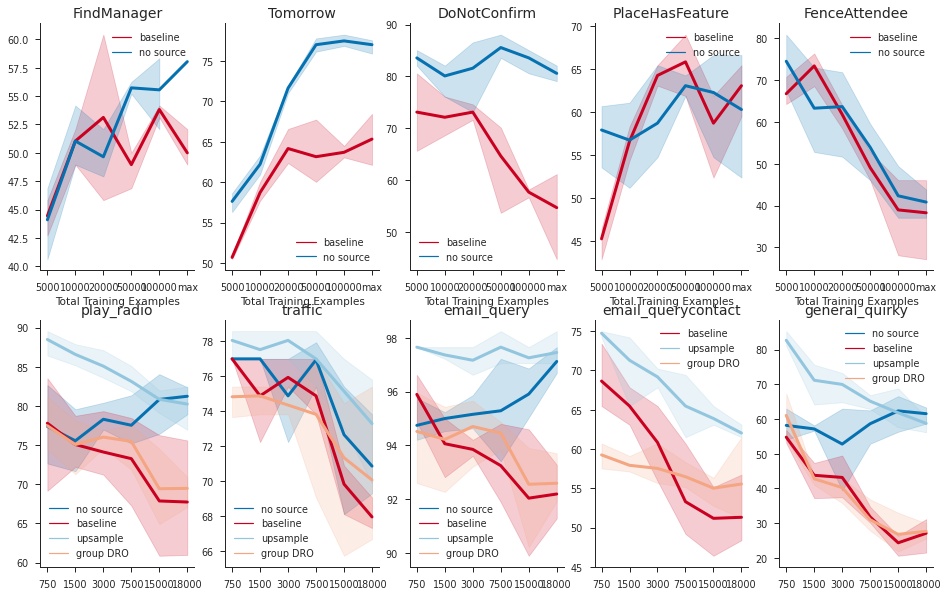

In [8]:
fm_baseline_path = "~/papers/incremental_function_learning/results/FindManager_transformer_test.csv"
fm_no_source_path = "~/papers/incremental_function_learning/results/no_source/FindManager_transformer_no_source.csv"
fm_paths_and_fxns = [("FindManager", fm_baseline_path, "baseline"), ("FindManager", fm_no_source_path, "no source"), ]


tom_baseline_path = "~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv"
tom_no_source_path = "~/papers/incremental_function_learning/results/no_source/Tomorrow_transformer_no_source.csv"
tom_paths_and_fxns = [("Tomorrow", tom_baseline_path, "baseline"), ("Tomorrow", tom_no_source_path, "no source"), ]

dnc_baseline_path = "~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv"
dnc_no_source_path = "~/papers/incremental_function_learning/results/no_source/DoNotConfirm_transformer_no_source.csv"
dnc_paths_and_fxns = [("DoNotConfirm", dnc_baseline_path, "baseline"), ("DoNotConfirm", dnc_no_source_path, "no source"), ]

phf_baseline_path = "~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv"
phf_no_source_path = "~/papers/incremental_function_learning/results/no_source/PlaceHasFeature_transformer_no_source.csv"
phf_paths_and_fxns = [("PlaceHasFeature", phf_baseline_path, "baseline"), ("PlaceHasFeature", phf_no_source_path, "no source"), ]

fa_baseline_path = "~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv"
fa_no_source_path = "~/papers/incremental_function_learning/results/no_source/FenceAttendee_transformer_no_source.csv"
fa_paths_and_fxns = [("FenceAttendee", fa_baseline_path, "baseline"), ("FenceAttendee", fa_no_source_path, "no source"), ]


all_paths = {"FindManager": fm_paths_and_fxns, "Tomorrow": tom_paths_and_fxns, "DoNotConfirm": dnc_paths_and_fxns, "PlaceHasFeature": phf_paths_and_fxns, "FenceAttendee": fa_paths_and_fxns}

fig, ax = plt.subplots(2, 5, figsize=(16, 10), sharex=False, sharey=False)
for i, fxn in enumerate(["FindManager", "Tomorrow", "DoNotConfirm", "PlaceHasFeature", "FenceAttendee"]): 
    plot_calflow(all_paths[fxn], fxn, show_legend=True, ax=ax[0,i])

data_dirs = [("/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/", "no source"), 
             ("/brtx/603-nvme1/estengel/intent_fixed_test/intent/", "baseline"),
             ("/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/", "upsample"),
             ("/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/", "group DRO")]

for i, intent in enumerate([50, 66, 15, 16, 27]): 
    plot_intent(data_dirs, intent, title=name_mapping[str(intent)], show_legend=True,  ax=ax[1,i], fxn_split=75)

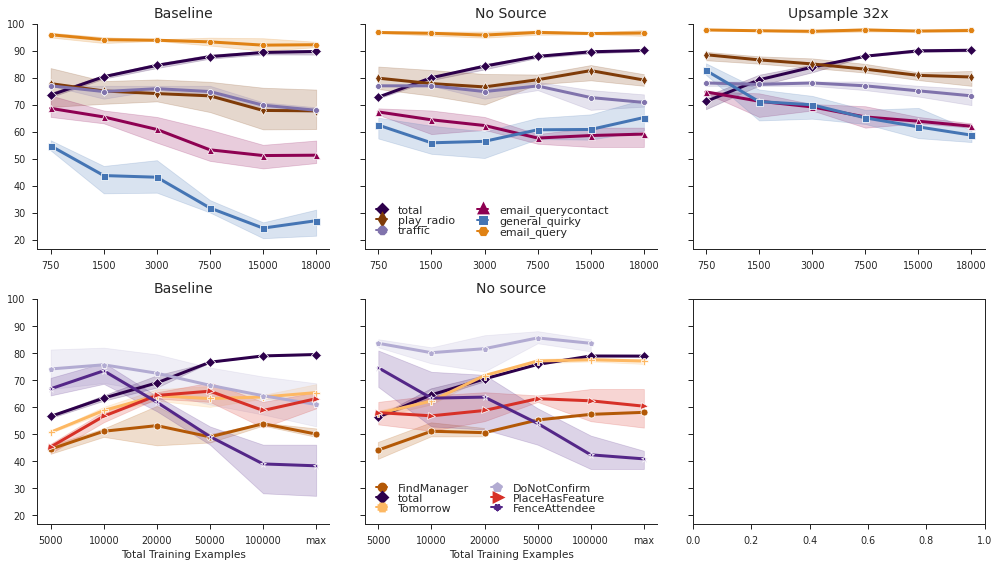

In [16]:

# cross-ways plot 
fig, ax = plt.subplots(2, 3, sharex=False, sharey=True, figsize=(14, 8))


plot_intent([(50, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"),
             (66, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (27, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/")], [12, 31, 64],
              title = f"Baseline", fxn_split=75, ax=ax[0, 0],
              axis_title=None,
              show_legend=False,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))

# plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"),
#              (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
#              (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/")], [12, 31, 64],
#               title = f"No Source", fxn_split=75, ax=ax[0, 1],
#               axis_title=None,
#               legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
#                               handletextpad=1.0, handler_map=handler_map))

plot_intent([(50, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/"),
             (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/"), 
             (27, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent_no_source/")], [12, 31, 64],
              title = f"No Source", fxn_split=75, ax=ax[0, 1],
              axis_title=None,
              show_legend=True,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))


# plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"),
#              (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/"), 
#              (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_16.0/")], [12, 31, 64],
#               title = f"Upsample 16x", fxn_split=75, ax=ax[0, 2],
#               axis_title=None,
#               legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
#                               handletextpad=1.0, handler_map=handler_map))


plot_intent([(50, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"),
             (66, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (16, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (27, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/"), 
             (15, "/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/")], [12, 31, 64],
              title = f"Upsample 32x", fxn_split=75, ax=ax[0, 2],
              axis_title=None,
              show_legend=False,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))



fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), 
         ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), 
         ("FenceAttendee", fenceattendee_data)]

plot_calflow(datas, 
            title = "Baseline", 
            prefix="test", 
            ax=ax[1,0], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            show_legend=False,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/FindManager_transformer_no_source.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/Tomorrow_transformer_no_source.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/DoNotConfirm_transformer_no_source.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/PlaceHasFeature_transformer_no_source.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/no_source/FenceAttendee_transformer_no_source.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), 
         ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), 
         ("FenceAttendee", fenceattendee_data)]

plot_calflow(datas, 
            title = "No source", 
            prefix="test", 
            ax=ax[1,1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            show_legend=True,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )




plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/large_main.pdf")

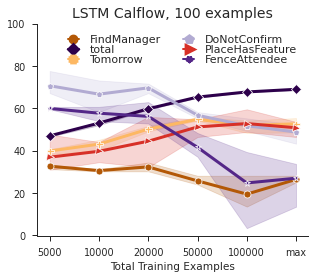

In [53]:
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_vanilla_lstm_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_vanilla_lstm_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_vanilla_lstm_100.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_vanilla_lstm_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_vanilla_lstm_test.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)

plot_calflow(datas, 
            title = "LSTM Calflow, 100 examples", 
            prefix="test", 
            ax=ax, 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=100,
            legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map)
            )

plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/lstm_calflow.pdf")

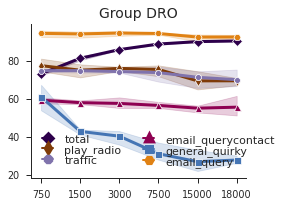

In [59]:


fig, ax = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(4,3))

plot_intent([(50, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"),
             (66, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (16, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (27, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/"), 
             (15, "/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/")], [12, 31, 64],
              title = f"Group DRO", fxn_split=75, ax=ax,
              axis_title=None,
              legend_kws=dict(ncol=2, fontsize=11, borderpad=0.5, labelspacing=0.0, handlelength=1,
                              handletextpad=1.0, handler_map=handler_map))
plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/intent_group_dro.pdf")